In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from params import Params
from universe import AssetUniverse
from data_loader import DataLoader
from backtester import AdaptiveBacktester, BuyAndHoldBacktester
from strategy import MomentumStrategy
import matplotlib.pyplot as plt
from analysis import StrategyAnalyzer
import pandas as pd
# Step 1: Set params and universe
params = Params(log_to_file=True)
#params.best_params_filename="surrogate_model_20250605_160058.pkl"
#params.load_overrides_from_file()
params = Params(
    # Universe
    top_n = 20,
    bull_weight_upper = 0.1,
    start_date = "2023-05-01",
    end_date = "2024-11-01",
    rebalance_interval = 1,
    horizons = [5, 10,  15, 20,  30],
    horizon_weights= [1.5, 1.25,1.0,0.75, 0.5],
    short_horizons = [2,   4,  7],
    short_horizon_weights= [1.5,1.0, 0.5],
    high_vol_zscore_threshold = 10000.0,
    lookback = 12
)
universe = AssetUniverse(params=params)

# Step 2: Load data
data = DataLoader(params=params, universe=universe)
data.download_data(overwrite=True)




# Step 3: Create strategies
momentum_strategy = MomentumStrategy(universe,params,data)
momentum_strategy.generate_signal()
# Step 4: Run backtests
adaptive = AdaptiveBacktester(data=data, strategy=momentum_strategy, params=params)
adaptive.run()

buy_and_hold = BuyAndHoldBacktester(data=data, params=params)
buy_and_hold.run()

# Optional: Show performance summary
from pandas import DataFrame
DataFrame(adaptive.performance_log + buy_and_hold.performance_log)



,Strategy,CAGR,Sharpe Ratio,Annual Return,Annual Volatility
0,adaptive,1.0760,1.5871,0.8824,0.5560
1,buy_and_hold,0.7145,1.2441,0.6939,0.5577


12


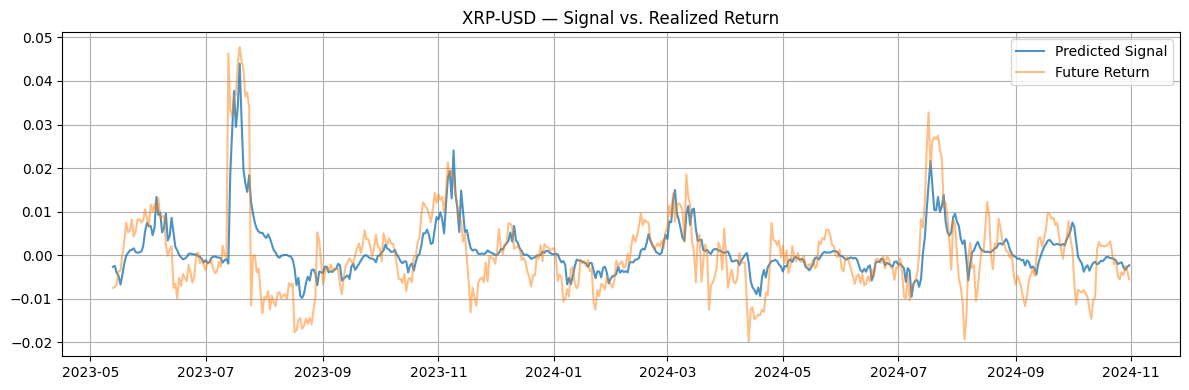

📈 Pearson correlation:  0.7569
📈 Spearman correlation: 0.5940
🎯 Directional hit rate:  74.91%


/Users/jordy/Desktop/ergosphere/analysis.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=decile_mean.index, y=decile_mean.values, palette="coolwarm")


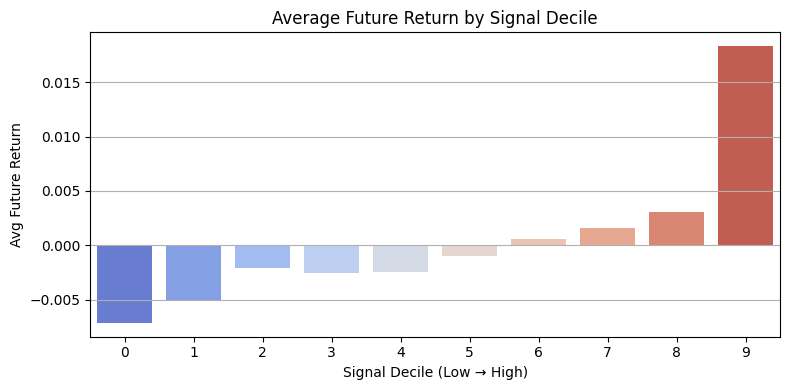

In [32]:
print(params.lookback)
analyzer = StrategyAnalyzer(
    prices=data.prices_daily,
    signal=momentum_strategy.signal,
    bh_result=buy_and_hold.result,
    adaptive_result=adaptive.result,
    adaptive_weights_log=adaptive.weights_log,
    params=params
)
analyzer.plot_signal_vs_realized_return("XRP-USD")

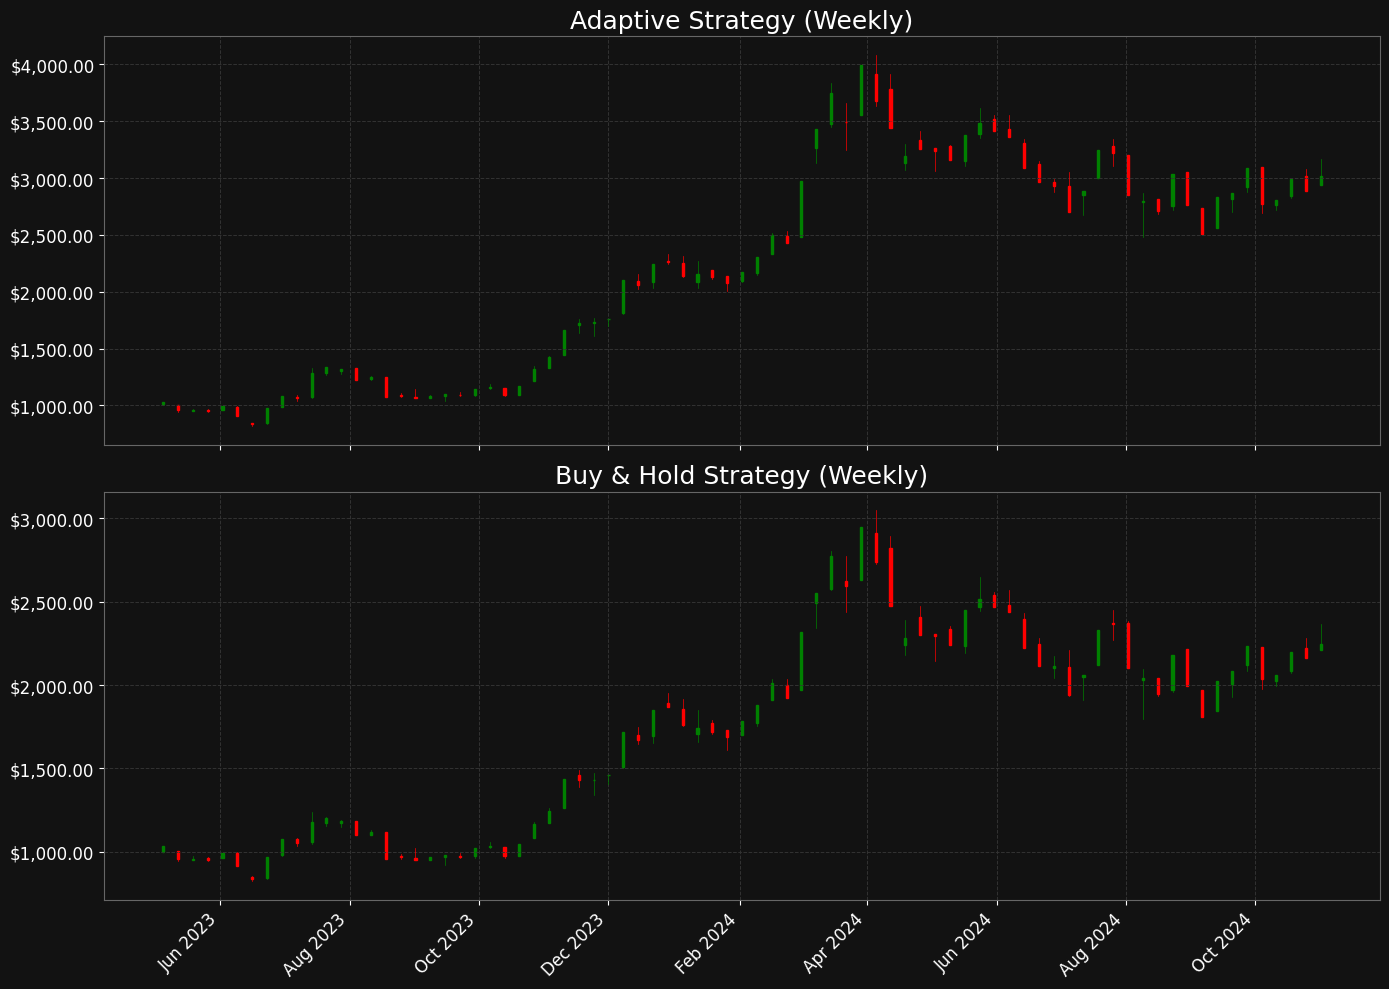

In [33]:

analyzer = StrategyAnalyzer(
    prices=data.prices_daily,
    signal=momentum_strategy.signal,
    bh_result=buy_and_hold.result,
    adaptive_result=adaptive.result,
    adaptive_weights_log=adaptive.weights_log,
    params=params
)

analyzer.plot_results(freq="W-FRI")  # or "D" for daily candlesticks if desired

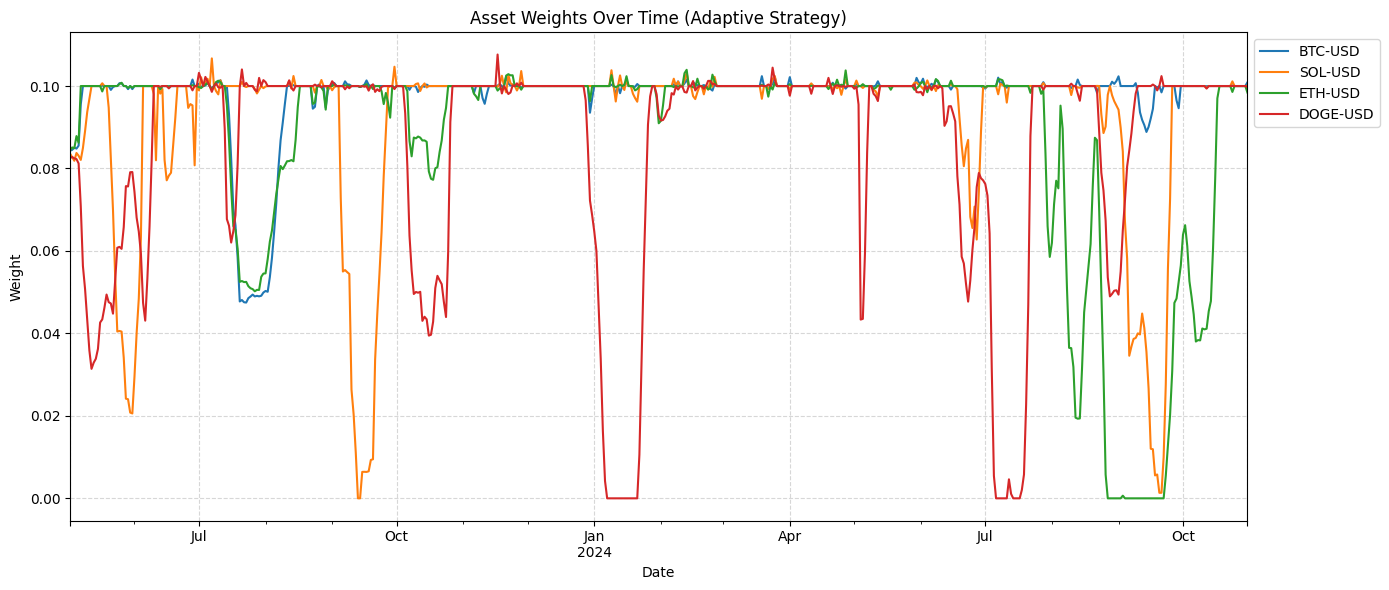

In [34]:
analyzer.plot_weights_over_time(top_n=4)

Initializing universe and loading data...
Generating momentum signals...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1698098.79it/s]


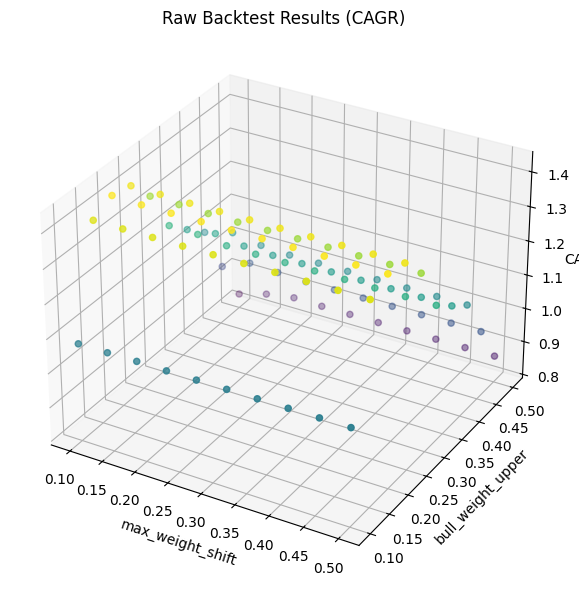

Optimal CAGR via RBF: 1.3718, at [0.26531971 0.21564823]
GP best predicted CAGR: 1.4241


In [48]:
import numpy as np
from datetime import datetime
from universe    import AssetUniverse
from params      import Params
from data_loader import DataLoader
from strategy    import MomentumStrategy
from backtester  import AdaptiveBacktester
from surrogate_model import SurrogateModel

params = Params(
    top_n = 20,
    bull_weight_upper = 0.1,
    start_date = "2023-05-01",
    end_date = "2024-11-01",
    rebalance_interval = 1,
    horizons = [5, 10,  15, 20,  30],
    horizon_weights= [1.5, 1.25,1.0,0.75, 0.5],
    short_horizons = [2,   4,  7],
    short_horizon_weights= [1.5,1.0, 0.5],
    high_vol_zscore_threshold = 10000.0,
    lookback = 12
)


# Initialize universe and load price data
print("Initializing universe and loading data...")
universe = AssetUniverse(params)
data = DataLoader(universe, params)
data.download_data(overwrite=True)  # Now holds data.prices, data.CVI, data.VIX

# Initialize strategy and generate signals
print("Generating momentum signals...")
strategy = MomentumStrategy(universe, params, data)
strategy.generate_signal()


# Custom parameter specifications for grid
param_specs = [
    ("max_weight_shift", np.linspace(0.1, 0.5, 10)),
    ("bull_weight_upper", np.linspace(0.1, 0.5, 10)),
]

# Initialize Surrogate Model
model = SurrogateModel(params, universe, data, param_specs=param_specs)

# Define grid
model.define_grid()  # Add this call if missing


# Run backtests with parallel processing
model.run_backtests(n_processes=4)

# Fit surrogate models
model.fit_surrogate_models()

# Optimize using RBF
opt_result = model.optimize_rbf()
print(f"Optimal CAGR via RBF: {-opt_result.fun:.4f}, at {opt_result.x}")

# GP sampling
x_query, y_pred, y_std = model.predict_gp(n_samples=1000)
print(f"GP best predicted CAGR: {np.max(y_pred):.4f}")

# Save the model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model.save(f"surrogate_model_{timestamp}.pkl", opt_result=opt_result)


In [52]:
holding_period = 1
results = []
import numpy as np
for i, rebalance_day in enumerate(momentum_strategy.signal.index[:-holding_period]):
    weights = analyzer.adaptive_weights_log[i]
    start_prices = data.prices_daily.loc[rebalance_day]
    end_day = momentum_strategy.signal.index[i + holding_period]
    end_prices = data.prices_daily.loc[end_day]

    realized_ret = (end_prices / start_prices) - 1
    weighted_ret = np.dot(weights, realized_ret)
    results.append((rebalance_day, weighted_ret))

realized = np.array([r for _, r in results])
neg_realized = realized[realized < 0]
pos_realized = realized[realized > 0]

print(f"Fraction negative days: {len(neg_realized) / len(realized):.3f}")
print(f"Mean loss on down days: {100*neg_realized.mean():.3f}%")
print(f"5th percentile loss: {np.percentile(neg_realized, 5):.3f}")
print(f"Worst single-day loss: {neg_realized.min():.2f}")

print(f"Fraction positive days: {len(pos_realized) / len(realized):.3f}")
print(f"Mean prof on up days: {100*pos_realized.mean():.3f}%")
print(f"95th percentile prof: {np.percentile(pos_realized, 95):.3f}")
print(f"Best single-day profit: {pos_realized.max():.3f}")

# day-to-day net expectancy
daily_exp = pos_realized.mean()*len(pos_realized) / len(realized) + neg_realized.mean()*len(neg_realized) / len(realized)
print(f"Effect return day to day: {daily_exp * 100:.3f}%")

# annualized (365 trading days)
yoy = (1 + daily_exp) ** 365 - 1
print(f"Effective YoY returns: {yoy * 100:.2f}%")

Fraction negative days: 0.461
Mean loss on down days: -1.962%
5th percentile loss: -0.060
Worst single-day loss: -0.10
Fraction positive days: 0.539
Mean prof on up days: 2.073%
95th percentile prof: 0.056
Best single-day profit: 0.197
Effect return day to day: 0.214%
Effective YoY returns: 117.92%
